##### Copyright 2018 The TensorFlow Authors.

In [7]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup and basic usage


To start eager execution, add `tf.enable_eager_execution()` to the beginning of
the program or console session. Do not add this operation to other modules that
the program calls.

In [8]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

tf.enable_eager_execution()

Now you can run TensorFlow operations and the results will return immediately::

In [9]:
tf.executing_eagerly()

True

In [11]:
x = [[2.]]
m = tf.matmul(x, x)
print("привет, {}".format(m))

привет, [[4.]]


Enabling eager execution changes how TensorFlow operations behave—now they
immediately evaluate and return their values to Python. `tf.Tensor` objects
reference concrete values instead of symbolic handles to nodes in a computational
graph. Since there isn't a computational graph to build and run later in a
session, it's easy to inspect results using `print()` or a debugger. Evaluating,
printing, and checking tensor values does not break the flow for computing
gradients.

Eager execution works nicely with [NumPy](http://www.numpy.org/). NumPy
operations accept `tf.Tensor` arguments. TensorFlow
[math operations](https://www.tensorflow.org/api_guides/python/math_ops) convert
Python objects and NumPy arrays to `tf.Tensor` objects. The
`tf.Tensor.numpy` method returns the object's value as a NumPy `ndarray`.

In [22]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [23]:
# Broadcasting support
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [24]:
# Operator overloading is supported
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [25]:
# Use NumPy values
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [26]:
# Obtain numpy value from a tensor:
print(a.numpy())
# => [[1 2]
#     [3 4]]

[[1 2]
 [3 4]]


The `tf.contrib.eager` module contains symbols available to both eager and graph execution
environments and is useful for writing code to [work with graphs](#work_with_graphs):

## Dynamic control flow

A major benefit of eager execution is that all the functionality of the host
language is available while your model is executing. So, for example,
it is easy to write [fizzbuzz](https://en.wikipedia.org/wiki/Fizz_buzz):

In [27]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

In [28]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


This has conditionals that depend on tensor values and it prints these values
at runtime.

## Build a model

Many machine learning models are represented by composing layers. When
using TensorFlow with eager execution you can either write your own layers or
use a layer provided in the `tf.keras.layers` package.

While you can use any Python object to represent a layer,
TensorFlow has `tf.keras.layers.Layer` as a convenient base class. Inherit from
it to implement your own layer:

In [29]:
class MySimpleLayer(tf.keras.layers.Layer):
  def __init__(self, output_units):
    super(MySimpleLayer, self).__init__()
    self.output_units = output_units

  def build(self, input_shape):
    # The build method gets called the first time your layer is used.
    # Creating variables on build() allows you to make their shape depend
    # on the input shape and hence removes the need for the user to specify
    # full shapes. It is possible to create variables during __init__() if
    # you already know their full shapes.
    self.kernel = self.add_variable(
      "kernel", [input_shape[-1], self.output_units])

  def call(self, input):
    # Override call() instead of __call__ so we can perform some bookkeeping.
    return tf.matmul(input, self.kernel)

Use `tf.keras.layers.Dense` layer instead  of `MySimpleLayer` above as it has
a superset of its functionality (it can also add a bias).

When composing layers into models you can use `tf.keras.Sequential` to represent
models which are a linear stack of layers. It is easy to use for basic models:

In [30]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, input_shape=(784,)),  # must declare input shape
  tf.keras.layers.Dense(10)
])

Instructions for updating:
Colocations handled automatically by placer.


Alternatively, organize models in classes by inheriting from `tf.keras.Model`.
This is a container for layers that is a layer itself, allowing `tf.keras.Model`
objects to contain other `tf.keras.Model` objects.

In [31]:
class MNISTModel(tf.keras.Model):
  def __init__(self):
    super(MNISTModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(units=10)
    self.dense2 = tf.keras.layers.Dense(units=10)

  def call(self, input):
    """Run the model."""
    result = self.dense1(input)
    result = self.dense2(result)
    result = self.dense2(result)  # reuse variables from dense2 layer
    return result

model = MNISTModel()

It's not required to set an input shape for the `tf.keras.Model` class since
the parameters are set the first time input is passed to the layer.

`tf.keras.layers` classes create and contain their own model variables that
are tied to the lifetime of their layer objects. To share layer variables, share
their objects.

## Eager training

### Computing gradients

[Automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)
is useful for implementing machine learning algorithms such as
[backpropagation](https://en.wikipedia.org/wiki/Backpropagation) for training
neural networks. During eager execution, use `tf.GradientTape` to trace
operations for computing gradients later.

`tf.GradientTape` is an opt-in feature to provide maximal performance when
not tracing. Since different operations can occur during each call, all
forward-pass operations get recorded to a "tape". To compute the gradient, play
the tape backwards and then discard. A particular `tf.GradientTape` can only
compute one gradient; subsequent calls throw a runtime error.

In [32]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(grad)  # => tf.Tensor([[ 2.]], shape=(1, 1), dtype=float32)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


### Train a model

The following example creates a multi-layer model that classifies the standard
MNIST handwritten digits. It demonstrates the optimizer and layer APIs to build
trainable graphs in an eager execution environment.

In [57]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()
dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [58]:
# Build the model
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])


Even without training, call the model and inspect the output in eager execution:

In [59]:
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[ 0.01911251 -0.01804457  0.00284918 -0.02342504 -0.03042551  0.00880419
  -0.00653339  0.07787658 -0.00415065 -0.01776585]]


While keras models have a builtin training loop (using the `fit` method), sometimes you need more customization. Here's an example, of a training loop implemented with eager:

In [60]:
optimizer = tf.train.AdamOptimizer()

loss_history = []

In [61]:
for (batch, (images, labels)) in enumerate(dataset.take(400)):
  if batch % 10 == 0:
    print('.', end='')
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)
    loss_value = tf.losses.sparse_softmax_cross_entropy(labels, logits)

  loss_history.append(loss_value.numpy())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables),
                            global_step=tf.train.get_or_create_global_step())

Instructions for updating:
Use tf.cast instead.


.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

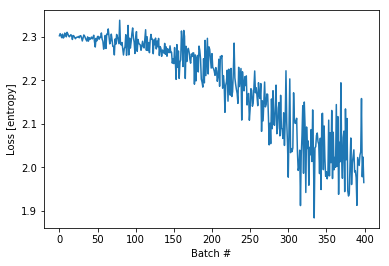

In [64]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')
plt.show()

### Variables and optimizers

`tf.Variable` objects store mutable `tf.Tensor` values accessed during
training to make automatic differentiation easier. The parameters of a model can
be encapsulated in classes as variables.

Better encapsulate model parameters by using `tf.Variable` with
`tf.GradientTape`. For example, the automatic differentiation example above
can be rewritten:

In [65]:
class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')
  def call(self, inputs):
    return inputs * self.W + self.B

# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random_normal([NUM_EXAMPLES])
noise = tf.random_normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])

# Define:
# 1. A model.
# 2. Derivatives of a loss function with respect to model parameters.
# 3. A strategy for updating the variables based on the derivatives.
model = Model()
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

# Training loop
for i in range(300):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]),
                            global_step=tf.train.get_or_create_global_step())
  if i % 20 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

Initial loss: 70.138
Loss at step 000: 67.347


Loss at step 020: 30.115
Loss at step 040: 13.786
Loss at step 060: 6.617
Loss at step 080: 3.467
Loss at step 100: 2.082


Loss at step 120: 1.472
Loss at step 140: 1.203


Loss at step 160: 1.084
Loss at step 180: 1.032
Loss at step 200: 1.009
Loss at step 220: 0.998
Loss at step 240: 0.994


Loss at step 260: 0.992
Loss at step 280: 0.991
Final loss: 0.991
W = 2.997786283493042, B = 2.0234856605529785


## Use objects for state during eager execution

With graph execution, program state (such as the variables) is stored in global
collections and their lifetime is managed by the `tf.Session` object. In
contrast, during eager execution the lifetime of state objects is determined by
the lifetime of their corresponding Python object.

### Variables are objects

During eager execution, variables persist until the last reference to the object
is removed, and is then deleted.

In [66]:
if tf.test.is_gpu_available():
  with tf.device("gpu:0"):
    v = tf.Variable(tf.random_normal([1000, 1000]))
    v = None  # v no longer takes up GPU memory

In [67]:
tf.test.is_gpu_available()

False

### Object-based saving

`tf.train.Checkpoint` can save and restore `tf.Variable`s to and from
checkpoints:

In [68]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [69]:
x.assign(2.)   # Assign a new value to the variables and save.
checkpoint_path = './ckpt/'
checkpoint.save('./ckpt/')

'./ckpt/-1'

In [70]:
x.assign(11.)  # Change the variable after saving.

# Restore values from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)  # => 2.0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


To save and load models, `tf.train.Checkpoint` stores the internal state of objects,
without requiring hidden variables. To record the state of a `model`,
an `optimizer`, and a global step, pass them to a `tf.train.Checkpoint`:

In [71]:
import os
import tempfile

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
checkpoint_dir = tempfile.mkdtemp()
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model,
                           optimizer_step=tf.train.get_or_create_global_step())

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Object-oriented metrics

`tfe.metrics` are stored as objects. Update a metric by passing the new data to
the callable, and retrieve the result using the `tfe.metrics.result` method,
for example:

In [73]:
m = tfe.metrics.Mean("loss")
m(0)
m(5)
m.result()  # => 2.5
m([8, 9])
m.result()  # => 5.5

<tf.Tensor: id=62827, shape=(), dtype=float64, numpy=5.5>

#### Summaries and TensorBoard

[TensorBoard](../guide/summaries_and_tensorboard.md) is a visualization tool for
understanding, debugging and optimizing the model training process. It uses
summary events that are written while executing the program.

`tf.contrib.summary` is compatible with both eager and graph execution
environments. Summary operations, such as `tf.contrib.summary.scalar`, are
inserted during model construction. For example, to record summaries once every
100 global steps:

In [75]:
global_step = tf.train.get_or_create_global_step()

logdir = "./tb/"
writer = tf.contrib.summary.create_file_writer(logdir)
writer.set_as_default()

for _ in range(10):
  global_step.assign_add(1)
  # Must include a record_summaries method
  with tf.contrib.summary.record_summaries_every_n_global_steps(100):
    # your model code goes here
    tf.contrib.summary.scalar('global_step', global_step)

## Advanced automatic differentiation topics

### Dynamic models

`tf.GradientTape` can also be used in dynamic models. This example for a
[backtracking line search](https://wikipedia.org/wiki/Backtracking_line_search)
algorithm looks like normal NumPy code, except there are gradients and is
differentiable, despite the complex control flow:

In [76]:
def line_search_step(fn, init_x, rate=1.0):
  with tf.GradientTape() as tape:
    # Variables are automatically recorded, but manually watch a tensor
    tape.watch(init_x)
    value = fn(init_x)
  grad = tape.gradient(value, init_x)
  grad_norm = tf.reduce_sum(grad * grad)
  init_value = value
  while value > init_value - rate * grad_norm:
    x = init_x - rate * grad
    value = fn(x)
    rate /= 2.0
  return x, value

### Additional functions to compute gradients

`tf.GradientTape` is a powerful interface for computing gradients, but there
is another [Autograd](https://github.com/HIPS/autograd)-style API available for
automatic differentiation. These functions are useful if writing math code with
only tensors and gradient functions, and without `tf.variables`:

* `tfe.gradients_function` —Returns a function that computes the derivatives
  of its input function parameter with respect to its arguments. The input
  function parameter must return a scalar value. When the returned function is
  invoked, it returns a list of `tf.Tensor` objects: one element for each
  argument of the input function. Since anything of interest must be passed as a
  function parameter, this becomes unwieldy if there's a dependency on many
  trainable parameters.
* `tfe.value_and_gradients_function` —Similar to
  `tfe.gradients_function`, but when the returned function is invoked, it
  returns the value from the input function in addition to the list of
  derivatives of the input function with respect to its arguments.

In the following example, `tfe.gradients_function` takes the `square`
function as an argument and returns a function that computes the partial
derivatives of `square` with respect to its inputs. To calculate the derivative
of `square` at `3`, `grad(3.0)` returns `6`.

In [77]:
def square(x):
  return tf.multiply(x, x)

grad = tfe.gradients_function(square)

In [78]:
square(3.).numpy()

9.0

In [79]:
grad(3.)[0].numpy()

6.0

In [80]:
# The second-order derivative of square:
gradgrad = tfe.gradients_function(lambda x: grad(x)[0])
gradgrad(3.)[0].numpy()

2.0

In [81]:
# The third-order derivative is None:
gradgradgrad = tfe.gradients_function(lambda x: gradgrad(x)[0])
gradgradgrad(3.)

[None]

In [82]:
# With flow control:
def abs(x):
  return x if x > 0. else -x

grad = tfe.gradients_function(abs)

In [83]:
grad(3.)[0].numpy()

1.0

In [84]:
grad(-3.)[0].numpy()

-1.0

### Custom gradients

Custom gradients are an easy way to override gradients in eager and graph
execution. Within the forward function, define the gradient with respect to the
inputs, outputs, or intermediate results. For example, here's an easy way to clip
the norm of the gradients in the backward pass:

In [85]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
  y = tf.identity(x)
  def grad_fn(dresult):
    return [tf.clip_by_norm(dresult, norm), None]
  return y, grad_fn

Custom gradients are commonly used to provide a numerically stable gradient for a
sequence of operations:

In [86]:
def log1pexp(x):
  return tf.log(1 + tf.exp(x))
grad_log1pexp = tfe.gradients_function(log1pexp)

In [87]:
# The gradient computation works fine at x = 0.
grad_log1pexp(0.)[0].numpy() 

0.5

In [88]:
# However, x = 100 fails because of numerical instability.
grad_log1pexp(100.)[0].numpy()

nan

Here, the `log1pexp` function can be analytically simplified with a custom
gradient. The implementation below reuses the value for `tf.exp(x)` that is
computed during the forward pass—making it more efficient by eliminating
redundant calculations:

In [90]:
@tf.custom_gradient
def log1pexp(x):
  e = tf.exp(x)
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.log(1 + e), grad

grad_log1pexp = tfe.gradients_function(log1pexp)

In [91]:
# As before, the gradient computation works fine at x = 0.
grad_log1pexp(0.)[0].numpy()

0.5

In [92]:
# And the gradient computation also works at x = 100.
grad_log1pexp(100.)[0].numpy()

1.0

## Performance

Computation is automatically offloaded to GPUs during eager execution. If you
want control over where a computation runs you can enclose it in a
`tf.device('/gpu:0')` block (or the CPU equivalent):

In [93]:
import time

def measure(x, steps):
  # TensorFlow initializes a GPU the first time it's used, exclude from timing.
  tf.matmul(x, x)
  start = time.time()
  for i in range(steps):
    x = tf.matmul(x, x)
  # tf.matmul can return before completing the matrix multiplication
  # (e.g., can return after enqueing the operation on a CUDA stream).
  # The x.numpy() call below will ensure that all enqueued operations
  # have completed (and will also copy the result to host memory,
  # so we're including a little more than just the matmul operation
  # time).
  _ = x.numpy()
  end = time.time()
  return end - start

shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# Run on CPU:
with tf.device("/cpu:0"):
  print("CPU: {} secs".format(measure(tf.random_normal(shape), steps)))

# Run on GPU, if available:
if tfe.num_gpus() > 0:
  with tf.device("/gpu:0"):
    print("GPU: {} secs".format(measure(tf.random_normal(shape), steps)))
else:
  print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:


CPU: 7.271521091461182 secs
GPU: not found


A `tf.Tensor` object can be copied to a different device to execute its
operations:

In [95]:
if tf.test.is_gpu_available():
  x = tf.random_normal([10, 10])

  x_gpu0 = x.gpu()
  x_cpu = x.cpu()

  _ = tf.matmul(x_cpu, x_cpu)    # Runs on CPU
  _ = tf.matmul(x_gpu0, x_gpu0)  # Runs on GPU:0

  if tfe.num_gpus() > 1:
    x_gpu1 = x.gpu(1)
    _ = tf.matmul(x_gpu1, x_gpu1)  # Runs on GPU:1

Benchmarks

For compute-heavy models, such as ResNet50 training on a GPU, eager execution performance is comparable to graph execution. But this gap grows larger for models with less computation and there is work to be done for optimizing hot code paths for models with lots of small operations.